# Считывание данных

In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model

features = 54
train_object_size = 20000
test_object_size = 30000
read_object_size = train_object_size + test_object_size

train_object = np.zeros((train_object_size, features))
train_ans = np.zeros(train_object_size)

test_object = np.zeros((test_object_size, features)) 
test_ans = np.zeros(test_object_size)

f = open('covtype.libsvm.binary.scale')
line_num = 0
for line in f:
    if (line_num == read_object_size):
        break
    line_object = line.split()
    len_line_object = len(line_object)
    for i in range(1, len_line_object):
        current_cell = line_object[i].split(':')
        current_num_feature = int(current_cell[0]) - 1
        current_feature = float(current_cell[1])
        bin_class = int(line_object[0])
        if (bin_class == 2):
            bin_class = -1
        if (line_num < train_object_size):
            train_ans[line_num] = bin_class
            train_object[line_num][current_num_feature] = current_feature
        else:
            test_ans[line_num - train_object_size] = bin_class
            test_object[line_num - train_object_size][current_num_feature] = current_feature
    line_num += 1
f.close()
print("Данные считались успешно!")

Данные считались успешно!


## Классовое соотношение

In [2]:
class1 = sum([int(train_ans[i] == 1) for i in range(train_object_size)]) #Посмотрим на соотношение классов в train.
class2 = sum([int(train_ans[i] == -1) for i in range(train_object_size)])
print("Количество первого класса в train = {0}, количество второго класса в train = {1}".format(class1, class2))

Количество первого класса в train = 13978, количество второго класса в train = 6022


In [3]:
class1 = sum([int(test_ans[i] == 1) for i in range(test_object_size)])
                                                                            #Посмотрим на соотношение классов в test.
class2 = sum([int(test_ans[i] == -1) for i in range(test_object_size)])
print("Количество первого класса в test = {0}, количество второго класса в test = {1}".format(class1, class2))

Количество первого класса в test = 7229, количество второго класса в test = 22771


## Функции

In [4]:
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [5]:
from numpy import linalg
import matplotlib.pyplot as plt
import copy
import time
%matplotlib inline

def logistic_loss(w, *args):
    X, y = args
    objects_size = y.shape[0]
    return sum([np.log(1 + np.exp(-y[i]*np.dot(X[i], w))) for i in range(objects_size)])

def grad_logistic_loss(w, *args):
    X, y = args
    objects_size = y.shape[0]
    return sum([-y[i]*X[i]/(1 + np.exp(y[i]*np.dot(X[i], w))) for i in range(objects_size)])

def hessian_logistic_loss(w, *args):
    X, y = args
    objects_size = y.shape[0]
    features = X.shape[1]
    ans = np.zeros((features, features))
    for i in range(objects_size):
        ans += np.exp(y[i]*np.dot(X[i], w))/((1 + np.exp(y[i]*np.dot(X[i], w)))**2)*np.dot(X[i].reshape(-1, 1),
                                                                X[i].reshape(1, -1))
    return ans

def L3_upper_bound(X):
    return 1/10*sum([linalg.norm(X[i])**3 for i in range(X.shape[0])])
  
def L2_upper_bound(X):
    return 1/4*sum([linalg.norm(X[i])**2 for i in range(X.shape[0])])

def plot_1_graph(title_name, x_name, y_name, solver, y_arr, x_arr = None):
    fig = plt.figure()
    plt.xlabel(x_name) 
    plt.ylabel(y_name) 
    plt.title(title_name) 
    y_name_print = y_name
    plt.grid(True)
    NumIter = len(y_arr)
    if (y_name == r'$||\nabla f_{loss}||_2$'):
        s3 = 'gradf'
        if (x_name == r'$Iter$'):
            s4 = 'iter'
            plt.semilogy([i for i in range(NumIter)], y_arr, label = solver)
            print("После NumIter = {0} итераций норма градиента функции = {1}".format(NumIter - 1, y_arr[NumIter - 1]))
        else:
            y_name_print = r'$\log_{10}(||\nabla f_{loss}||_2)$'
            s4 = 'time'
            s = [10 for n in range(NumIter)]
            plt.scatter(x_arr, np.log10(y_arr), label = solver, s = s)
            print("За время Time = {0} секунд норма градиента функции = {1}".format(x_arr[NumIter - 1], 
                                                                                    y_arr[NumIter - 1]))
    else:
        s3 = 'f'
        if (x_name == r'$Iter$'):
            s4 = 'iter'
            plt.plot([i for i in range(NumIter)], y_arr, label = solver)
            print("После NumIter = {0} итераций значение функции = {1}".format(NumIter - 1, y_arr[NumIter - 1]))
        else:
            s4 = 'time'
            s = [10 for n in range(NumIter)]
            plt.scatter(x_arr, y_arr, label = solver, s = s)
            print("За время Time = {0} секунд значение функции = {1}".format(x_arr[NumIter - 1], 
                                                                                    y_arr[NumIter - 1]))
    plt.ylabel(y_name_print) 
    plt.legend()
    s1 = title_name
    b = '$\;'
    for char in b:
        s1 = s1.replace(char, "")
    s1 = s1.split(' ')
    s = ''
    for strings in s1:
        if strings != '':
            s += strings + '_'
    s1 = s[:-1]
    s2 = solver.replace(" ", "_")
    file_name = s1 + "_" + s2 + "_" + s3 + "_" + s4 + ".pdf"
    fig.savefig(file_name)
    plt.show()

# Неускоренный метод Ньютона с кубической регуляризацией

iter = 0
||s|| - lambda = 0.0
iter = 1
||s|| - lambda = 0.0
iter = 2
||s|| - lambda = 0.0
iter = 3
||s|| - lambda = 0.0
iter = 4
||s|| - lambda = 0.0
iter = 5
||s|| - lambda = 0.0
iter = 6
||s|| - lambda = 0.0
iter = 7
||s|| - lambda = 0.0
iter = 8
||s|| - lambda = 0.0
iter = 9
||s|| - lambda = 0.0
iter = 10
||s|| - lambda = 0.0
iter = 11
||s|| - lambda = 0.0
iter = 12
||s|| - lambda = 0.0
iter = 13
||s|| - lambda = 0.0
iter = 14
||s|| - lambda = 0.0
iter = 15
||s|| - lambda = 0.0
iter = 16
||s|| - lambda = 0.0
iter = 17
||s|| - lambda = 0.0
iter = 18
||s|| - lambda = 0.0
iter = 19
||s|| - lambda = 0.0
iter = 20
||s|| - lambda = 0.0
iter = 21
||s|| - lambda = 0.0
iter = 22
||s|| - lambda = -5.169878828456423e-26
iter = 23
||s|| - lambda = 2.5849394142282115e-26
iter = 24
||s|| - lambda = 2.5849394142282115e-26
iter = 25
||s|| - lambda = 1.2924697071141057e-26
iter = 26
||s|| - lambda = 1.2924697071141057e-26
iter = 27
||s|| - lambda = 0.0
iter = 28
||s|| - lambda = 0.0
iter = 29
||s|| 

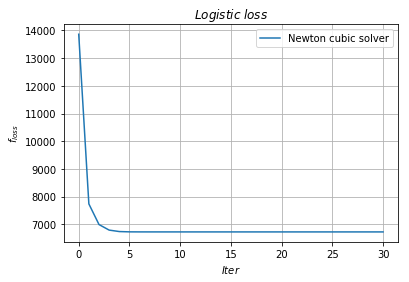

После NumIter = 30 итераций норма градиента функции = 6.792901841829857e-11


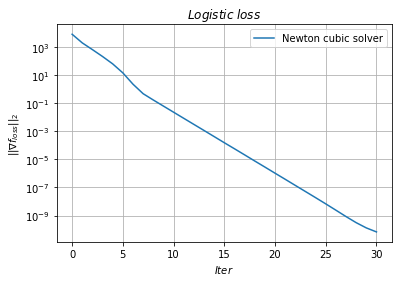

In [41]:
from numpy import linalg
    
def Newton_cubic_step(x_k, NumIterStep, *args):
    g, H, M, eps = args
    g_new = g*M/2
    lambda_ans = eps
    k = 0
    while (k < NumIterStep):
        H_lambda = H + lambda_ans*np.identity(H.shape[0])
        L = linalg.cholesky(H_lambda)
        s = linalg.solve(H_lambda, -g_new)
        w = linalg.solve(L, s)
        lambda_next = lambda_ans*(1 - 
            (lambda_ans - linalg.norm(s))*(linalg.norm(s)**2)/(linalg.norm(s)**3 + (linalg.norm(w)**2)*(lambda_ans**2)))
        if (lambda_next > 0):
            lambda_ans = lambda_next
        else:
            break
        k += 1
    H_lambda = H + lambda_ans*np.identity(H.shape[0])
    s = linalg.solve(H_lambda, -g_new)
    r_opt1 = lambda_ans*2/M
    print("||s|| - lambda = {0}".format(linalg.norm(s) - lambda_ans))
    r_opt2 = 0
    h_opt1 = -np.dot(linalg.inv(H + M/2*r_opt1*np.identity(H.shape[0])), g)
    h_opt2 = -np.dot(linalg.pinv(H), g)
    val_1 = np.dot(g, h_opt1) + 1/2*np.dot(np.dot(H, h_opt1), h_opt1) + M/6*(linalg.norm(h_opt1)**3)
    val_2 = np.dot(g, h_opt2) + 1/2*np.dot(np.dot(H, h_opt2), h_opt2) + M/6*(linalg.norm(h_opt2)**3)
    if (val_1 < val_2):
        h_opt = h_opt1
    else:
        h_opt = h_opt2
    return x_k + h_opt

def Newton_cubic_solver_iter(x0, NumIter, NumIterStep, f, grad_f, hessian_f, L0, eps, *args):
    k = 0
    x_k = copy.deepcopy(x0)
    farr = np.zeros(NumIter + 1)
    fgradarr = np.zeros(NumIter + 1)
    M_k = L0
    while (k < NumIter):
        print("iter = {0}".format(k))
        f_current = f(x_k, *args)
        grad_f_current = grad_f(x_k, *args)
        hessian_f_current = hessian_f(x_k, *args)
        farr[k] = f_current
        fgradarr[k] = linalg.norm(grad_f_current)
        while(1):
            T_k = Newton_cubic_step(x_k, NumIterStep, *(grad_f_current, hessian_f_current, M_k, eps))
            if (f(T_k, *args) > f_current):
                M_k = 2*M_k
                print("M_k = {0}".format(M_k))
            else:
                break
        x_k = T_k
        M_k = max(1/2*M_k, L0)
        k += 1
    f_current = f(x_k, *args)
    grad_f_current = grad_f(x_k, *args)
    farr[k] = f_current
    fgradarr[k] = linalg.norm(grad_f_current)
    return x_k, farr, fgradarr
    
train_const_feature = np.array([np.array([1]) for i in range(train_object_size)]) #добавим фиктивный признак
train_extended_object = copy.deepcopy(train_object)
train_extended_object = np.column_stack((train_extended_object, train_const_feature[:, 0]))

features_num = features + 1
w0 = np.zeros(features_num)
NumIter = 30
NumIterStep = 100
L0 = 1e-10
eps = 1e-10

args = (train_extended_object, train_ans)
xans_newton_cubic_iter, farr_newton_cubic_iter, fgradarr_newton_cubic_iter = Newton_cubic_solver_iter(w0, NumIter, 
                        NumIterStep, logistic_loss, grad_logistic_loss, hessian_logistic_loss,  L0, eps, *args)

plot_1_graph(r'$Logistic \; loss$', r'$Iter$', r'$f_{loss}$', 'Newton cubic solver', farr_newton_cubic_iter)
plot_1_graph(r'$Logistic \; loss$', r'$Iter$', r'$||\nabla f_{loss}||_2$', 'Newton cubic solver', 
                                                                                         fgradarr_newton_cubic_iter)

||s|| - lambda = 0.0
||s|| - lambda = 0.0
За время Time = 4.776789303999976 секунд значение функции = 6989.525541648329


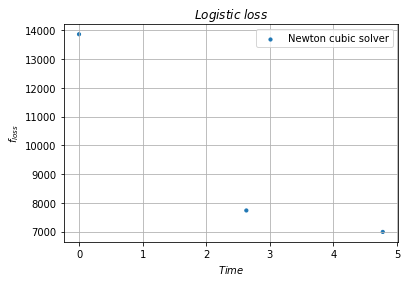

За время Time = 4.776789303999976 секунд норма градиента функции = 649.0325403743653


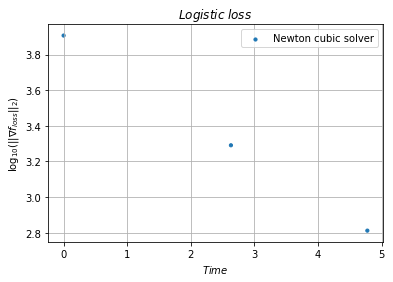

In [42]:
def Newton_cubic_solver_time(x0, start_time, work_time, NumIterStep, f, grad_f, hessian_f, L0, eps, *args):
    Time = [time.process_time() - start_time]
    end_time = start_time + work_time
    k = 0
    x_k = copy.deepcopy(x0)
    farr = []
    fgradarr = []
    f_current = f(x_k, *args)
    grad_f_current = grad_f(x_k, *args)
    farr = [f_current]
    fgradarr = [linalg.norm(grad_f_current)]
    hessian_f_current = hessian_f(x_k, *args)
    M_k = L0
    while (time.process_time() < end_time):
        while(1):
            T_k = Newton_cubic_step(x_k, NumIterStep, *(grad_f_current, hessian_f_current, M_k, eps))
            if (f(T_k, *args) > f_current):
                M_k = 2*M_k
            else:
                break
        x_k = T_k
        M_k = max(1/2*M_k, L0)
        f_current = f(x_k, *args)
        grad_f_current = grad_f(x_k, *args)
        Time.append(time.process_time() - start_time)
        farr.append(f_current)
        fgradarr.append(linalg.norm(grad_f_current))
        hessian_f_current = hessian_f(x_k, *args)
    return Time, x_k, farr, fgradarr

work_time = 5
w0 = np.zeros(features_num)
NumIterStep = 100
L0 = 1e-10
eps = 1e-10

args = (train_extended_object, train_ans)
Time, xans_newton_cubic_time, farr_newton_cubic_time, fgradarr_newton_cubic_time = Newton_cubic_solver_time(w0, 
time.process_time(), work_time, NumIterStep, logistic_loss, grad_logistic_loss, hessian_logistic_loss,  L0, eps, *args)

plot_1_graph(r'$Logistic \; loss$', r'$Time$', r'$f_{loss}$', 'Newton cubic solver', farr_newton_cubic_time, Time)
plot_1_graph(r'$Logistic \; loss$', r'$Time$', r'$||\nabla f_{loss}||_2$', 'Newton cubic solver', 
                                                                                fgradarr_newton_cubic_time, Time)

# Ускоренный метод Ньютона с кубической регуляризацией

## Автоматическое дифференцирование

В следующей ячейке в качестве константы L3 выбирается L3/parts, parts = 100000.

||s|| - lambda = 2.220446049250313e-16
iter = 1
||s|| - lambda = 0.0
iter = 2
||s|| - lambda = 6.661338147750939e-16
iter = 3
||s|| - lambda = 0.0
iter = 4
||s|| - lambda = 0.0
iter = 5
||s|| - lambda = -1.7763568394002505e-15
iter = 6
||s|| - lambda = 2.6645352591003757e-15
iter = 7
||s|| - lambda = 2.220446049250313e-16
iter = 8
||s|| - lambda = 0.0
iter = 9
||s|| - lambda = 6.661338147750939e-16
iter = 10
||s|| - lambda = 2.6645352591003757e-15
iter = 11
||s|| - lambda = 5.218048215738236e-15
iter = 12
||s|| - lambda = 2.398081733190338e-14
iter = 13
||s|| - lambda = 1.1324274851176597e-14
iter = 14
||s|| - lambda = -1.1435297153639112e-14
После NumIter = 15 итераций значение функции = 6736.857030272935


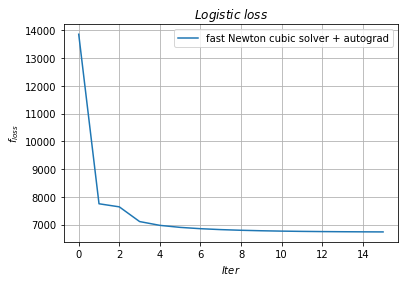

После NumIter = 15 итераций норма градиента функции = 30.816774096059596


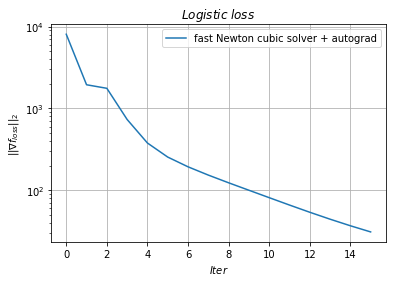

In [9]:
import autograd.numpy as np

from autograd import grad    
from autograd import jacobian

grad_logistic_loss_auto = grad(logistic_loss)       # Obtain its gradient function   
hess_logistic_loss_auto = jacobian(grad_logistic_loss_auto)

def calc_v_k(x0, N, s_k):
    eps = 1e-10
    norm = linalg.norm(s_k)
    if norm < eps:
        return x0
    else:
        return x0 - (2/N)**0.5*s_k/norm

def fast_Newton_cubic_solver_iter(x0, NumIter, NumIterStep, f, grad_f, hessian_f, L0, eps, *args):
    N = 12*L0
    M = 2*L0
    k = 0
    s_k = np.zeros(x0.shape[0])
    x_k = copy.deepcopy(x0)
    farr = np.zeros(NumIter + 1)
    fgradarr = np.zeros(NumIter + 1)
    grad_f_current = grad_f(x_k, *args)
    hessian_f_current = hessian_f(x_k, *args)
    farr[0] = f(x_k, *args)
    fgradarr[0] = linalg.norm(grad_f_current)
    x_k = Newton_cubic_step(x_k, NumIterStep, *(grad_f_current, hessian_f_current, L0, eps))
    k += 1
    f_current = f(x_k, *args)
    grad_f_current = grad_f(x_k, *args)
    farr[k] = f_current
    fgradarr[k] = linalg.norm(grad_f_current)
    while (k < NumIter):
        print("iter = {0}".format(k))
        v_k = calc_v_k(x0, N, s_k)
        y_k = k/(k + 3)*x_k + 3/(k + 3)*v_k
        grad_f_current = grad_f(y_k, *args)
        hessian_f_current = hessian_f(y_k, *args)
        x_k = Newton_cubic_step(y_k, NumIterStep, *(grad_f_current, hessian_f_current, M, eps))
        gradf_xk = grad_f(x_k, *args)
        s_k += (k + 1)*(k + 2)/2*gradf_xk
        k += 1
        farr[k] = f(x_k, *args)
        fgradarr[k] = linalg.norm(gradf_xk)
    return x_k, farr, fgradarr
    
train_const_feature = np.array([np.array([1]) for i in range(train_object_size)]) #добавим фиктивный признак
train_extended_object = copy.deepcopy(train_object)
train_extended_object = np.column_stack((train_extended_object, train_const_feature[:, 0]))

features_num = features + 1
w0 = np.zeros(features_num)
NumIter = 15
NumIterStep = 100
parts = 100000
L0 = L3_upper_bound(train_extended_object)/parts
eps = 1e-10

args = (train_extended_object, train_ans)
xans_fast_newton_cubic, farr_fast_newton_cubic, fgradarr_fast_newton_cubic = fast_Newton_cubic_solver_iter(w0, NumIter,
                        NumIterStep, logistic_loss, grad_logistic_loss_auto, hessian_logistic_loss,  L0, eps, *args)

plot_1_graph(r'$Logistic \; loss$', r'$Iter$', r'$f_{loss}$', 'fast Newton cubic solver + autograd', 
                                                                                          farr_fast_newton_cubic)
plot_1_graph(r'$Logistic \; loss$', r'$Iter$', r'$||\nabla f_{loss}||_2$', 'fast Newton cubic solver + autograd',
                                                                                     fgradarr_fast_newton_cubic)

||s|| - lambda = 2.220446049250313e-16
За время Time = 12.212173108000002 секунд значение функции = 7751.3838270071565


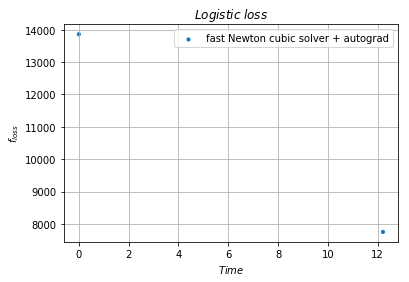

За время Time = 12.212173108000002 секунд норма градиента функции = 1943.8266845501396


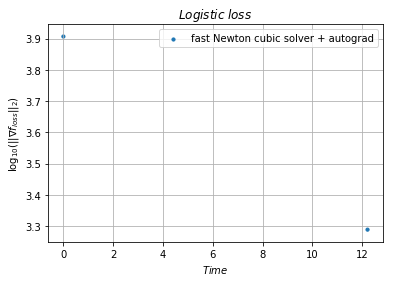

In [15]:
def fast_Newton_cubic_solver_time(x0, start_time, work_time, NumIterStep, f, grad_f, hessian_f, L0, eps, *args):
    Time = [time.process_time() - start_time]
    end_time = start_time + work_time
    N = 12*L0
    M = 2*L0
    k = 0
    s_k = np.zeros(x0.shape[0])
    x_k = copy.deepcopy(x0)
    grad_f_current = grad_f(x_k, *args)
    hessian_f_current = hessian_f(x_k, *args)
    farr = [f(x_k, *args)]
    fgradarr = [linalg.norm(grad_f_current)]
    x_k = Newton_cubic_step(x_k, NumIterStep, *(grad_f_current, hessian_f_current, L0, eps))
    Time.append(time.process_time() - start_time)
    k += 1
    farr.append(f(x_k, *args))
    grad_f_current = grad_f(x_k, *args)
    fgradarr.append(linalg.norm(grad_f_current))
    while (time.process_time() < end_time):
        v_k = calc_v_k(x0, N, s_k)
        y_k = k/(k + 3)*x_k + 3/(k + 3)*v_k
        grad_f_current = grad_f(y_k, *args)
        hessian_f_current = hessian_f(y_k, *args)
        x_k = Newton_cubic_step(y_k, NumIterStep, *(grad_f_current, hessian_f_current, M, eps))
        Time.append(time.process_time() - start_time)
        gradf_xk = grad_f(x_k, *args)
        farr.append(f(x_k, *args))
        fgradarr.append(linalg.norm(gradf_xk))
        s_k += (k + 1)*(k + 2)/2*gradf_xk
        k += 1
    return Time, x_k, farr, fgradarr

work_time = 5
w0 = np.zeros(features_num)
NumIter = 30
NumIterStep = 100
parts = 100000
L0 = L3_upper_bound(train_extended_object)/parts
eps = 1e-10

args = (train_extended_object, train_ans)
Time, xans_fast_newton_time, farr_fast_newton_time, fgradarr_fast_newton_time = fast_Newton_cubic_solver_time(w0, 
time.process_time(), work_time, NumIterStep, logistic_loss, grad_logistic_loss_auto, hessian_logistic_loss, L0, 
                                                                                                            eps, *args)

plot_1_graph(r'$Logistic \; loss$', r'$Time$', r'$f_{loss}$', 'fast Newton cubic solver + autograd', 
                                                                                     farr_fast_newton_time, Time)
plot_1_graph(r'$Logistic \; loss$', r'$Time$', r'$||\nabla f_{loss}||_2$', 'fast Newton cubic solver + autograd', 
                                                                                fgradarr_fast_newton_time, Time)

## Явные формулы

### Выбор большой константы Липшица

||s|| - lambda = 0.0
iter = 1
||s|| - lambda = 0.0
iter = 2
||s|| - lambda = 0.0
iter = 3
||s|| - lambda = 0.0
iter = 4
||s|| - lambda = 1.8189894035458565e-12
iter = 5
||s|| - lambda = 1.8189894035458565e-12
iter = 6
||s|| - lambda = 0.0
iter = 7
||s|| - lambda = 0.0
iter = 8
||s|| - lambda = 0.0
iter = 9
||s|| - lambda = 0.0
iter = 10
||s|| - lambda = 0.0
iter = 11
||s|| - lambda = 9.094947017729282e-13
iter = 12
||s|| - lambda = 9.094947017729282e-13
iter = 13
||s|| - lambda = 9.094947017729282e-13
iter = 14
||s|| - lambda = 9.094947017729282e-13
iter = 15
||s|| - lambda = 0.0
iter = 16
||s|| - lambda = 9.094947017729282e-13
iter = 17
||s|| - lambda = 9.094947017729282e-13
iter = 18
||s|| - lambda = 9.094947017729282e-13
iter = 19
||s|| - lambda = 0.0
iter = 20
||s|| - lambda = 9.094947017729282e-13
iter = 21
||s|| - lambda = 9.094947017729282e-13
iter = 22
||s|| - lambda = 9.094947017729282e-13
iter = 23
||s|| - lambda = 9.094947017729282e-13
iter = 24
||s|| - lambda = 0.0
iter = 2

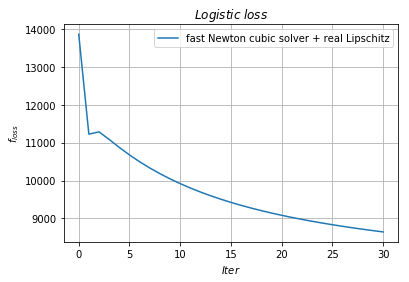

После NumIter = 30 итераций норма градиента функции = 1063.713317003


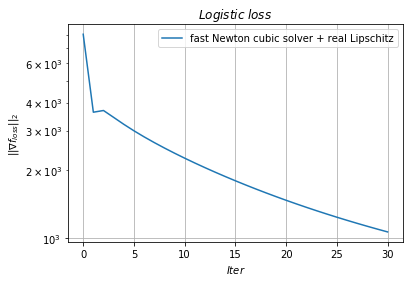

In [19]:
train_const_feature = np.array([np.array([1]) for i in range(train_object_size)]) #добавим фиктивный признак
train_extended_object = copy.deepcopy(train_object)
train_extended_object = np.column_stack((train_extended_object, train_const_feature[:, 0]))

features_num = features + 1
w0 = np.zeros(features_num)
NumIter = 30
NumIterStep = 100
L0 = L3_upper_bound(train_extended_object)
eps = 1e-10

args = (train_extended_object, train_ans)
xans_fast_newton_cubic, farr_fast_newton_cubic, fgradarr_fast_newton_cubic = fast_Newton_cubic_solver_iter(w0, NumIter,
                        NumIterStep, logistic_loss, grad_logistic_loss, hessian_logistic_loss,  L0, eps, *args)

plot_1_graph(r'$Logistic \; loss$', r'$Iter$', r'$f_{loss}$', 'fast Newton cubic solver + real Lipschitz', 
                                                                                          farr_fast_newton_cubic)
plot_1_graph(r'$Logistic \; loss$', r'$Iter$', r'$||\nabla f_{loss}||_2$', 'fast Newton cubic solver + real Lipschitz',
                                                                                     fgradarr_fast_newton_cubic)

||s|| - lambda = 0.0
||s|| - lambda = 0.0
||s|| - lambda = 0.0
За время Time = 5.8663994280000225 секунд значение функции = 11084.813828233617


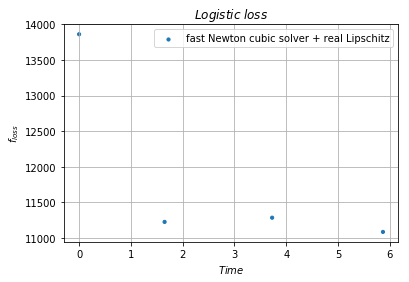

За время Time = 5.8663994280000225 секунд норма градиента функции = 3440.043636644217


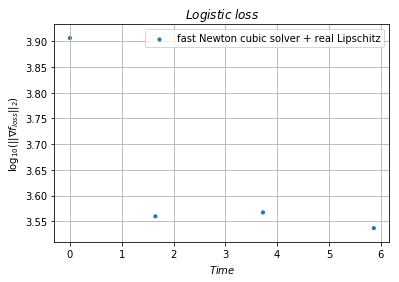

In [43]:
work_time = 5
w0 = np.zeros(features_num)
NumIter = 30
NumIterStep = 100
parts = 100000
L0 = L3_upper_bound(train_extended_object)
eps = 1e-10

args = (train_extended_object, train_ans)
Time, xans_fast_newton_time, farr_fast_newton_time, fgradarr_fast_newton_time = fast_Newton_cubic_solver_time(w0, 
time.process_time(), work_time, NumIterStep, logistic_loss, grad_logistic_loss, hessian_logistic_loss, L0, eps, *args)

plot_1_graph(r'$Logistic \; loss$', r'$Time$', r'$f_{loss}$', 'fast Newton cubic solver + real Lipschitz', 
                                                                                     farr_fast_newton_time, Time)
plot_1_graph(r'$Logistic \; loss$', r'$Time$', r'$||\nabla f_{loss}||_2$', 'fast Newton cubic solver + real Lipschitz', 
                                                                                fgradarr_fast_newton_time, Time)

### Промежуточный случай

||s|| - lambda = 0.0
iter = 1
||s|| - lambda = 0.0
iter = 2
||s|| - lambda = -4.440892098500626e-16
iter = 3
||s|| - lambda = -3.774758283725532e-15
iter = 4
||s|| - lambda = 0.0
iter = 5
||s|| - lambda = 0.0
iter = 6
||s|| - lambda = -2.886579864025407e-15
iter = 7
||s|| - lambda = 8.881784197001252e-16
iter = 8
||s|| - lambda = 0.0
iter = 9
||s|| - lambda = -6.661338147750939e-16
iter = 10
||s|| - lambda = 0.0
iter = 11
||s|| - lambda = 2.220446049250313e-16
iter = 12
||s|| - lambda = 1.1102230246251565e-16
iter = 13
||s|| - lambda = 6.328271240363392e-15
iter = 14
||s|| - lambda = -8.43769498715119e-15
iter = 15
||s|| - lambda = 2.7977620220553945e-14
iter = 16
||s|| - lambda = 1.1102230246251565e-16
iter = 17
||s|| - lambda = -1.1102230246251565e-16
iter = 18
||s|| - lambda = 0.0
iter = 19
||s|| - lambda = 2.1094237467877974e-14
iter = 20
||s|| - lambda = 5.551115123125783e-16
iter = 21
||s|| - lambda = 1.1102230246251565e-16
iter = 22
||s|| - lambda = 4.107825191113079e-15
iter = 

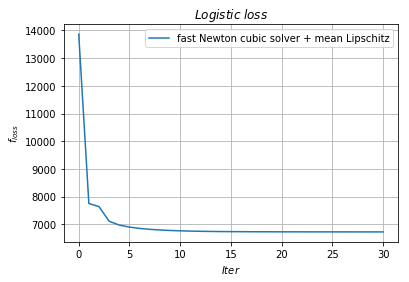

После NumIter = 30 итераций норма градиента функции = 6.235277823953405


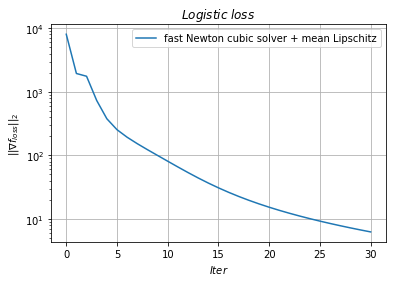

In [44]:
train_const_feature = np.array([np.array([1]) for i in range(train_object_size)]) #добавим фиктивный признак
train_extended_object = copy.deepcopy(train_object)
train_extended_object = np.column_stack((train_extended_object, train_const_feature[:, 0]))

features_num = features + 1
w0 = np.zeros(features_num)
NumIter = 30
NumIterStep = 100
parts = 100000
L0 = L3_upper_bound(train_extended_object)/parts
eps = 1e-10

args = (train_extended_object, train_ans)
xans_fast_newton_cubic, farr_fast_newton_cubic, fgradarr_fast_newton_cubic = fast_Newton_cubic_solver_iter(w0, NumIter,
                        NumIterStep, logistic_loss, grad_logistic_loss, hessian_logistic_loss,  L0, eps, *args)

plot_1_graph(r'$Logistic \; loss$', r'$Iter$', r'$f_{loss}$', 'fast Newton cubic solver + mean Lipschitz', 
                                                                                          farr_fast_newton_cubic)
plot_1_graph(r'$Logistic \; loss$', r'$Iter$', r'$||\nabla f_{loss}||_2$', 'fast Newton cubic solver + mean Lipschitz',
                                                                                     fgradarr_fast_newton_cubic)

||s|| - lambda = 0.0
||s|| - lambda = 0.0
||s|| - lambda = -4.440892098500626e-16
За время Time = 5.850365215000011 секунд значение функции = 7110.3520315068945


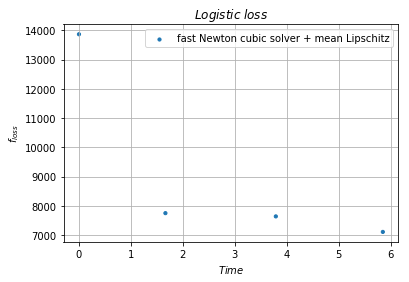

За время Time = 5.850365215000011 секунд норма градиента функции = 730.8796388157745


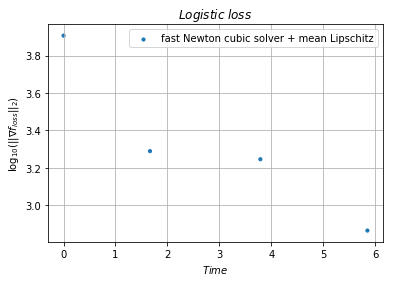

In [45]:
work_time = 5
w0 = np.zeros(features_num)
NumIter = 30
NumIterStep = 100
parts = 100000
L0 = L3_upper_bound(train_extended_object)/parts
eps = 1e-10

args = (train_extended_object, train_ans)
Time, xans_fast_newton_time, farr_fast_newton_time, fgradarr_fast_newton_time = fast_Newton_cubic_solver_time(w0, 
time.process_time(), work_time, NumIterStep, logistic_loss, grad_logistic_loss, hessian_logistic_loss, L0, eps, *args)

plot_1_graph(r'$Logistic \; loss$', r'$Time$', r'$f_{loss}$', 'fast Newton cubic solver + mean Lipschitz',
                                                                                     farr_fast_newton_time, Time)
plot_1_graph(r'$Logistic \; loss$', r'$Time$', r'$||\nabla f_{loss}||_2$', 'fast Newton cubic solver + mean Lipschitz', 
                                                                                fgradarr_fast_newton_time, Time)

### Маленькая константа Липшица

||s|| - lambda = -7.771561172376096e-16
iter = 1
||s|| - lambda = 0.0
iter = 2
||s|| - lambda = -5.551115123125783e-16
iter = 3
||s|| - lambda = 0.0
iter = 4
||s|| - lambda = -1.3211653993039363e-14
iter = 5
||s|| - lambda = 6.661338147750939e-16
iter = 6
||s|| - lambda = -1.0935696792557792e-14
iter = 7
||s|| - lambda = 1.6653345369377348e-16
iter = 8
||s|| - lambda = 3.885780586188048e-16
iter = 9
||s|| - lambda = 1.6653345369377348e-15
iter = 10
||s|| - lambda = -8.382183835919932e-15
iter = 11
||s|| - lambda = 2.6645352591003757e-15
iter = 12
||s|| - lambda = -1.7763568394002505e-15
iter = 13
||s|| - lambda = -4.440892098500626e-16
iter = 14
||s|| - lambda = -1.659783421814609e-14
iter = 15
||s|| - lambda = -1.27675647831893e-15
iter = 16
||s|| - lambda = 2.886579864025407e-15
iter = 17
||s|| - lambda = 0.0
iter = 18
||s|| - lambda = -8.326672684688674e-16
iter = 19
||s|| - lambda = 9.43689570931383e-16
iter = 20
||s|| - lambda = 7.93809462606987e-15
iter = 21
||s|| - lambda = 5.55

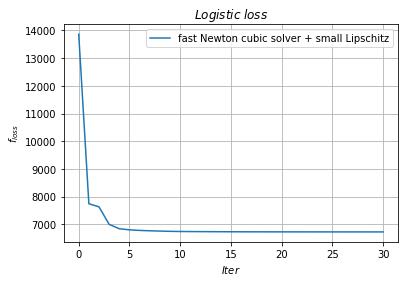

После NumIter = 30 итераций норма градиента функции = 4.013049862049302


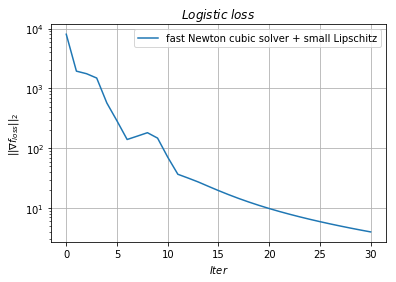

In [70]:
train_const_feature = np.array([np.array([1]) for i in range(train_object_size)]) #добавим фиктивный признак
train_extended_object = copy.deepcopy(train_object)
train_extended_object = np.column_stack((train_extended_object, train_const_feature[:, 0]))

features_num = features + 1
w0 = np.zeros(features_num)
NumIter = 30
NumIterStep = 100
L0 = 1e-1
eps = 1e-10

args = (train_extended_object, train_ans)
xans_fast_newton_cubic, farr_fast_newton_cubic, fgradarr_fast_newton_cubic = fast_Newton_cubic_solver_iter(w0, NumIter,
                        NumIterStep, logistic_loss, grad_logistic_loss, hessian_logistic_loss,  L0, eps, *args)

plot_1_graph(r'$Logistic \; loss$', r'$Iter$', r'$f_{loss}$', 'fast Newton cubic solver + small Lipschitz', 
                                                                                          farr_fast_newton_cubic)
plot_1_graph(r'$Logistic \; loss$', r'$Iter$', r'$||\nabla f_{loss}||_2$', 'fast Newton cubic solver + small Lipschitz',
                                                                                     fgradarr_fast_newton_cubic)

||s|| - lambda = -7.771561172376096e-16
||s|| - lambda = 0.0
||s|| - lambda = -5.551115123125783e-16
За время Time = 6.202664743999776 секунд значение функции = 6997.2877859100745


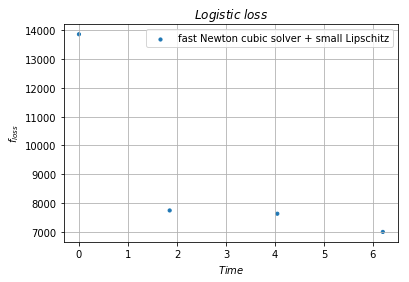

За время Time = 6.202664743999776 секунд норма градиента функции = 1495.3105142985683


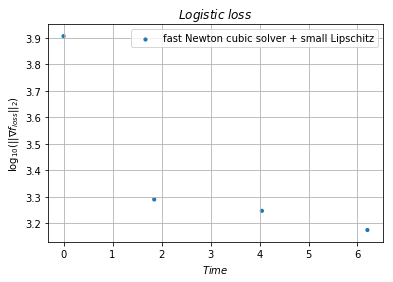

In [68]:
work_time = 5
w0 = np.zeros(features_num)
NumIter = 30
NumIterStep = 100
parts = 100000
L0 = 1e-1
eps = 1e-10

args = (train_extended_object, train_ans)
Time, xans_fast_newton_time, farr_fast_newton_time, fgradarr_fast_newton_time = fast_Newton_cubic_solver_time(w0, 
time.process_time(), work_time, NumIterStep, logistic_loss, grad_logistic_loss, hessian_logistic_loss, L0, eps, *args)

plot_1_graph(r'$Logistic \; loss$', r'$Time$', r'$f_{loss}$', 'fast Newton cubic solver + small Lipschitz',
                                                                                     farr_fast_newton_time, Time)
plot_1_graph(r'$Logistic \; loss$', r'$Time$', r'$||\nabla f_{loss}||_2$', 'fast Newton cubic solver + small Lipschitz', 
                                                                                fgradarr_fast_newton_time, Time)

### Адаптация константы Липшица

iter = 0
||s|| - lambda = 6.106226635438361e-16
iter = 1
||s|| - lambda = 0.0
iter = 2
||s|| - lambda = 0.0
M_k = 0.02
||s|| - lambda = 0.0
M_k = 0.04
||s|| - lambda = 4.440892098500626e-16
M_k = 0.08
||s|| - lambda = 0.0
M_k = 0.16
||s|| - lambda = 0.0
M_k = 0.32
||s|| - lambda = -3.552713678800501e-15
M_k = 0.64
||s|| - lambda = 0.0
M_k = 1.28
||s|| - lambda = 0.0
M_k = 2.56
||s|| - lambda = 0.0
M_k = 5.12
||s|| - lambda = 1.4210854715202004e-14
M_k = 10.24
||s|| - lambda = 0.0
M_k = 20.48
||s|| - lambda = 0.0
M_k = 40.96
||s|| - lambda = 5.684341886080802e-14
M_k = 81.92
||s|| - lambda = 1.1368683772161603e-13
M_k = 163.84
||s|| - lambda = 0.0
M_k = 327.68
||s|| - lambda = 0.0
M_k = 655.36
||s|| - lambda = 2.2737367544323206e-13
M_k = 1310.72
||s|| - lambda = 4.547473508864641e-13
iter = 3
||s|| - lambda = 5.684341886080802e-14
iter = 4
||s|| - lambda = 0.0
iter = 5
||s|| - lambda = 0.0
iter = 6
||s|| - lambda = 0.0
iter = 7
||s|| - lambda = -4.973799150320701e-14
iter = 8
||s|| - l

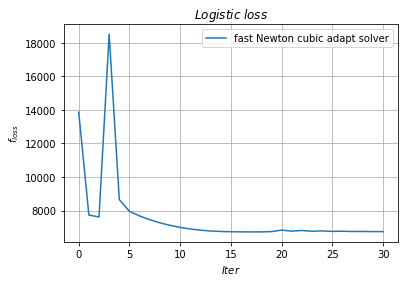

После NumIter = 30 итераций норма градиента функции = 259.5905424506085


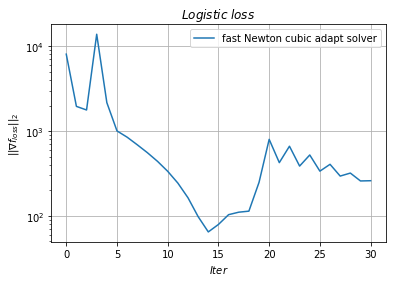

In [71]:
def fast_Newton_cubic_adapt_solver_iter(x0, NumIter, NumIterStep, f, grad_f, hessian_f, L0, eps, *args):
    N_k = 12*L0
    M_k = 2*L0
    k = 0
    s_k = np.zeros(x0.shape[0])
    x_k = copy.deepcopy(x0)
    farr = np.zeros(NumIter + 1)
    fgradarr = np.zeros(NumIter + 1)
    grad_f_current = grad_f(x_k, *args)
    hessian_f_current = hessian_f(x_k, *args)
    f_current = f(x_k, *args)
    farr[0] = f_current
    fgradarr[0] = linalg.norm(grad_f_current)
    print("iter = {0}".format(k))
    while(1):
        T_k = Newton_cubic_step(x_k, NumIterStep, *(grad_f_current, hessian_f_current, M_k, eps))
        if (f(T_k, *args) > f_current):
            M_k = 2*M_k
            print("M_k = {0}".format(M_k))
        else:
            break
    x_k = T_k
    M_k = max(1/2*M_k, L0)
    N_k = 6*M_k
    k += 1
    f_current = f(x_k, *args)
    grad_f_current = grad_f(x_k, *args)
    farr[k] = f_current
    fgradarr[k] = linalg.norm(grad_f_current)
    while (k < NumIter):
        print("iter = {0}".format(k))
        v_k = calc_v_k(x0, N_k, s_k)
        y_k = k/(k + 3)*x_k + 3/(k + 3)*v_k
        f_current = f(y_k, *args)
        grad_f_current = grad_f(y_k, *args)
        hessian_f_current = hessian_f(y_k, *args)
        while(1):
            T_k = Newton_cubic_step(y_k, NumIterStep, *(grad_f_current, hessian_f_current, M_k, eps))
            if (f(T_k, *args) > f_current):
                M_k = 2*M_k
                print("M_k = {0}".format(M_k))
            else:
                break
        x_k = T_k
        M_k = max(1/2*M_k, L0)
        N_k = 6*M_k
        gradf_xk = grad_f(x_k, *args)
        s_k += (k + 1)*(k + 2)/2*gradf_xk
        k += 1
        farr[k] = f(x_k, *args)
        fgradarr[k] = linalg.norm(gradf_xk)
    return x_k, farr, fgradarr

train_const_feature = np.array([np.array([1]) for i in range(train_object_size)]) #добавим фиктивный признак
train_extended_object = copy.deepcopy(train_object)
train_extended_object = np.column_stack((train_extended_object, train_const_feature[:, 0]))

features_num = features + 1
w0 = np.zeros(features_num)
NumIter = 30
NumIterStep = 100
L0 = 1e-2
eps = 1e-10

args = (train_extended_object, train_ans)
xans_fast_newton_cubic, farr_fast_newton_cubic, fgradarr_fast_newton_cubic = fast_Newton_cubic_adapt_solver_iter(w0, 
            NumIter, NumIterStep, logistic_loss, grad_logistic_loss, hessian_logistic_loss,  L0, eps, *args)

plot_1_graph(r'$Logistic \; loss$', r'$Iter$', r'$f_{loss}$', 'fast Newton cubic adapt solver', farr_fast_newton_cubic)
plot_1_graph(r'$Logistic \; loss$', r'$Iter$', r'$||\nabla f_{loss}||_2$', 'fast Newton cubic adapt solver',
                                                                                     fgradarr_fast_newton_cubic)

||s|| - lambda = 6.106226635438361e-16
||s|| - lambda = 0.0
За время Time = 4.537573054999939 секунд значение функции = 7621.441893719297


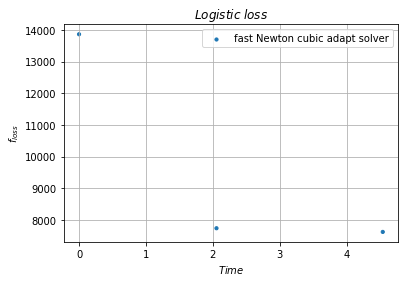

За время Time = 4.537573054999939 секунд норма градиента функции = 1771.183048744807


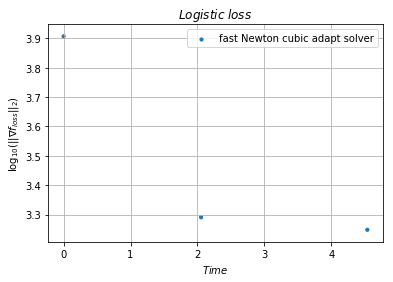

In [73]:
def fast_Newton_cubic_adapt_solver_time(x0, start_time, work_time, NumIterStep, f, grad_f, hessian_f, L0, eps, *args):
    Time = [time.process_time() - start_time]
    end_time = start_time + work_time
    N_k = 12*L0
    M_k = 2*L0
    k = 0
    s_k = np.zeros(x0.shape[0])
    x_k = copy.deepcopy(x0)
    grad_f_current = grad_f(x_k, *args)
    hessian_f_current = hessian_f(x_k, *args)
    f_current = f(x_k, *args)
    farr = [f_current]
    fgradarr = [linalg.norm(grad_f_current)]
    while(1):
        T_k = Newton_cubic_step(x_k, NumIterStep, *(grad_f_current, hessian_f_current, M_k, eps))
        if (f(T_k, *args) > f_current):
            M_k = 2*M_k
            print("M_k = {0}".format(M_k))
        else:
            break
    x_k = T_k
    Time.append(time.process_time() - start_time)
    M_k = max(1/2*M_k, L0)
    N_k = 6*M_k
    k += 1
    farr.append(f(x_k, *args))
    grad_f_current = grad_f(x_k, *args)
    fgradarr.append(linalg.norm(grad_f_current))
    while (time.process_time() < end_time):
        v_k = calc_v_k(x0, N_k, s_k)
        y_k = k/(k + 3)*x_k + 3/(k + 3)*v_k
        f_current = f(y_k, *args)
        grad_f_current = grad_f(y_k, *args)
        hessian_f_current = hessian_f(y_k, *args)
        while(1):
            T_k = Newton_cubic_step(y_k, NumIterStep, *(grad_f_current, hessian_f_current, M_k, eps))
            if (f(T_k, *args) > f_current):
                M_k = 2*M_k
                print("M_k = {0}".format(M_k))
            else:
                break
        x_k = T_k
        Time.append(time.process_time() - start_time)
        M_k = max(1/2*M_k, L0)
        N_k = 6*M_k
        gradf_xk = grad_f(x_k, *args)
        farr.append(f(x_k, *args))
        fgradarr.append(linalg.norm(gradf_xk))
        s_k += (k + 1)*(k + 2)/2*gradf_xk
        k += 1
    return Time, x_k, farr, fgradarr

work_time = 5
w0 = np.zeros(features_num)
NumIter = 30
NumIterStep = 100
parts = 100000
L0 = 1e-2
eps = 1e-10

args = (train_extended_object, train_ans)
Time, xans_fast_newton_time, farr_fast_newton_time, fgradarr_fast_newton_time = fast_Newton_cubic_adapt_solver_time(w0, 
time.process_time(), work_time, NumIterStep, logistic_loss, grad_logistic_loss, hessian_logistic_loss, L0, eps, *args)

plot_1_graph(r'$Logistic \; loss$', r'$Time$', r'$f_{loss}$', 'fast Newton cubic adapt solver',
                                                                                     farr_fast_newton_time, Time)
plot_1_graph(r'$Logistic \; loss$', r'$Time$', r'$||\nabla f_{loss}||_2$', 'fast Newton cubic adapt solver', 
                                                                                fgradarr_fast_newton_time, Time)

# Неадаптивный БГМ

После NumIter = 30 итераций значение функции = 7335.087264691151


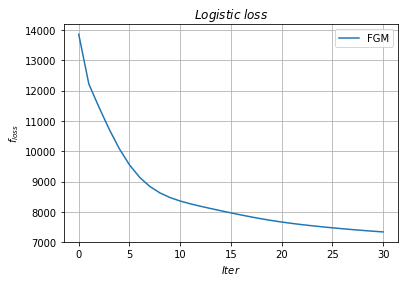

После NumIter = 30 итераций норма градиента функции = 174.21994006848414


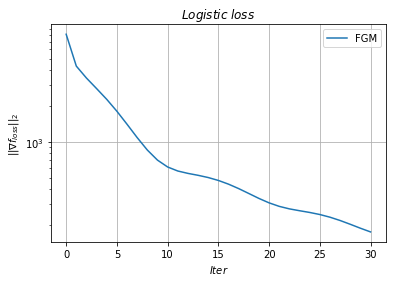

In [76]:
import matplotlib.pyplot as plt
import copy
import time
%matplotlib inline

def FGM_iter(NumIter, x0, f, gradf, L, *args):
    k = 0
    v_k = copy.deepcopy(x0)
    x_k = copy.deepcopy(x0)
    A_k = 0
    farr = np.zeros(NumIter + 1)
    fgradarr = np.zeros(NumIter + 1)
    farr[0] = f(x_k, *args)
    fgradarr[0] = linalg.norm(gradf(x_k, *args))
    while (k < NumIter):
        a_k = (1 + (1 + 2 * L * A_k)**0.5) / L 
        y_k = (A_k*x_k + a_k*v_k)/(A_k + a_k)
        x_k = y_k - 1/L*gradf(y_k, *args)
        gradf_xk = gradf(x_k, *args)
        v_k = v_k - a_k * gradf_xk
        A_k = A_k + a_k
        k += 1
        farr[k] = f(x_k, *args)
        fgradarr[k] = linalg.norm(gradf_xk)
    return x_k, farr, fgradarr

features_extended = features + 1
w0 = np.zeros(features_extended)
NumIter = 30

train_const_feature = np.array([np.array([1]) for i in range(train_object_size)]) #добавим фиктивный признак
train_extended_object = copy.deepcopy(train_object)
train_extended_object = np.column_stack((train_extended_object, train_const_feature[:, 0]))
L = L2_upper_bound(train_extended_object)

args = (train_extended_object, train_ans)
xans_fgm, farr_fgm, fgradarr_fgm = FGM_iter(NumIter, w0, logistic_loss, grad_logistic_loss, L, *args)

plot_1_graph(r'$Logistic \; loss$', r'$Iter$', r'$f_{loss}$', 'FGM', farr_fgm)
plot_1_graph(r'$Logistic \; loss$', r'$Iter$', r'$||\nabla f_{loss}||_2$', 'FGM', fgradarr_fgm)

За время Time = 5.224922917000185 секунд значение функции = 9550.612093858359


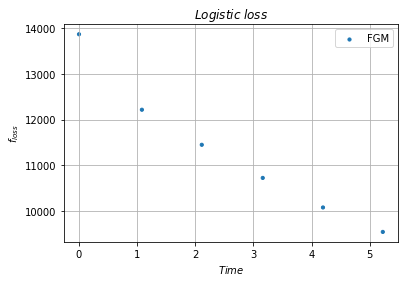

За время Time = 5.224922917000185 секунд норма градиента функции = 1810.220403531661


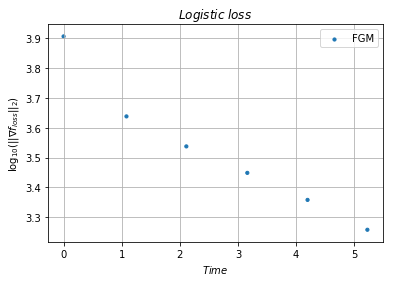

In [83]:
def FGM_time(start_time, work_time, x0, f, grad_f, L, *args):
    Time = [time.process_time() - start_time]
    end_time = start_time + work_time
    k = 0
    v_k = copy.deepcopy(x0)
    x_k = copy.deepcopy(x0)
    A_k = 0
    farr = [f(x_k, *args)]
    fgradarr = [linalg.norm(grad_f(x_k, *args))]
    while (time.process_time() < end_time):
        a_k = (1 + (1 + 2 * L * A_k)**0.5) / L 
        y_k = (A_k*x_k + a_k*v_k)/(A_k + a_k)
        x_k = y_k - 1/L*grad_f(y_k, *args)
        gradf_xk = grad_f(x_k, *args)
        v_k = v_k - a_k * gradf_xk
        A_k = A_k + a_k
        Time.append(time.process_time() - start_time)
        farr.append(f(x_k, *args))
        fgradarr.append(linalg.norm(grad_f(x_k, *args)))
    return Time, x_k, farr, fgradarr

features_extended = features + 1
w0 = np.zeros(features_extended)
NumIter = 30

train_const_feature = np.array([np.array([1]) for i in range(train_object_size)]) #добавим фиктивный признак
train_extended_object = copy.deepcopy(train_object)
train_extended_object = np.column_stack((train_extended_object, train_const_feature[:, 0]))
L = L2_upper_bound(train_extended_object)

work_time = 5
w0 = np.zeros(features_num)

args = (train_extended_object, train_ans)
Time, xans_fgm_time, farr_fgm_time, fgradarr_fgm_time = FGM_time(time.process_time(), work_time, w0, logistic_loss, 
                                                                              grad_logistic_loss, L, *args)

plot_1_graph(r'$Logistic \; loss$', r'$Time$', r'$f_{loss}$', 'FGM', farr_fgm_time, Time)
plot_1_graph(r'$Logistic \; loss$', r'$Time$', r'$||\nabla f_{loss}||_2$', 'FGM', fgradarr_fgm_time, Time)

# Сравнение всех методов

iter = 0
||s|| - lambda = 0.0
iter = 1
||s|| - lambda = 0.0
iter = 2
||s|| - lambda = 0.0
iter = 3
||s|| - lambda = 0.0
iter = 4
||s|| - lambda = 0.0
iter = 5
||s|| - lambda = 0.0
iter = 6
||s|| - lambda = 0.0
iter = 7
||s|| - lambda = 0.0
iter = 8
||s|| - lambda = 0.0
iter = 9
||s|| - lambda = 0.0
iter = 10
||s|| - lambda = 0.0
iter = 11
||s|| - lambda = 0.0
iter = 12
||s|| - lambda = 0.0
iter = 13
||s|| - lambda = 0.0
iter = 14
||s|| - lambda = 0.0
iter = 15
||s|| - lambda = 0.0
iter = 16
||s|| - lambda = 0.0
iter = 17
||s|| - lambda = 0.0
iter = 18
||s|| - lambda = 0.0
iter = 19
||s|| - lambda = 0.0
iter = 20
||s|| - lambda = 0.0
iter = 21
||s|| - lambda = 0.0
iter = 22
||s|| - lambda = -5.169878828456423e-26
iter = 23
||s|| - lambda = 2.5849394142282115e-26
iter = 24
||s|| - lambda = 2.5849394142282115e-26
iter = 25
||s|| - lambda = 1.2924697071141057e-26
iter = 26
||s|| - lambda = 1.2924697071141057e-26
iter = 27
||s|| - lambda = 0.0
iter = 28
||s|| - lambda = 0.0
iter = 29
||s|| 

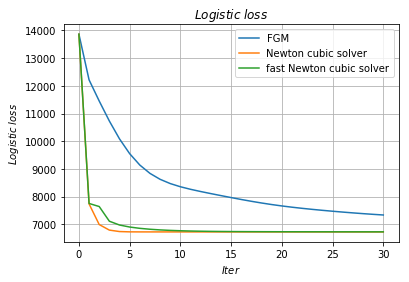

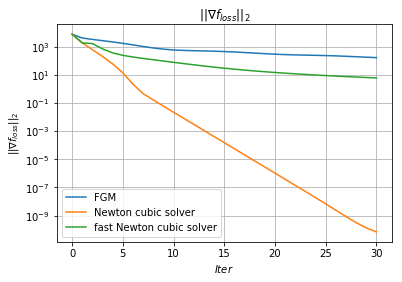

Newton cubic solver: после NumIter = 30 итераций значение функции = 6723.720030361996, норма градиента = 6.792901841829857e-11
fast Newton cubic solver: после NumIter = 30 итераций значение функции = 6726.461359355619, норма градиента = 6.235277823953405
FGM: после NumIter = 30 итераций значение функции = 7335.087264691151, норма градиента = 174.21994006848414


In [79]:
features_extended = features + 1
w0 = np.zeros(features_extended)
NumIter = 30

train_const_feature = np.array([np.array([1]) for i in range(train_object_size)]) #добавим фиктивный признак
train_extended_object = copy.deepcopy(train_object)
train_extended_object = np.column_stack((train_extended_object, train_const_feature[:, 0]))
L = L2_upper_bound(train_extended_object)
NumIterStep = 100
parts = 100000
L0 = 1e-10
eps = 1e-10

fig = plt.figure()
plt.xlabel(r'$Iter$') 
plt.ylabel(r'$Logistic \; loss$') 
plt.title(r'$Logistic \; loss$') 
args = (train_extended_object, train_ans)
xans_fgm, farr_fgm, fgradarr_fgm = FGM_iter(NumIter, w0, logistic_loss, grad_logistic_loss, L, *args)

xans_newton_cubic, farr_newton_cubic, fgradarr_newton_cubic = Newton_cubic_solver_iter(w0, NumIter, NumIterStep, 
                                        logistic_loss, grad_logistic_loss, hessian_logistic_loss, L0, eps, *args)

L0 = L3_upper_bound(train_extended_object)/parts
xans_fast_newton_cubic, farr_fast_newton_cubic, fgradarr_fast_newton_cubic = fast_Newton_cubic_solver_iter(w0, NumIter,
                        NumIterStep, logistic_loss, grad_logistic_loss, hessian_logistic_loss,  L0, eps, *args)

plt.plot([i for i in range(NumIter + 1)], farr_fgm, label = 'FGM')
plt.plot([i for i in range(NumIter + 1)], farr_newton_cubic, label = 'Newton cubic solver')
plt.plot([i for i in range(NumIter + 1)], farr_fast_newton_cubic, label = 'fast Newton cubic solver')
plt.legend()
plt.grid(True) 
fig.savefig('log_loss_all_f_iter.pdf')
plt.show()

fig = plt.figure()
plt.xlabel(r'$Iter$') 
plt.ylabel(r'$||\nabla f_{loss}||_2$') 
plt.title(r'$||\nabla f_{loss}||_2$') 
plt.semilogy([i for i in range(NumIter + 1)], fgradarr_fgm, label = 'FGM')
plt.semilogy([i for i in range(NumIter + 1)], fgradarr_newton_cubic, label = 'Newton cubic solver')
plt.semilogy([i for i in range(NumIter + 1)], fgradarr_fast_newton_cubic, label = 'fast Newton cubic solver')
plt.legend()
plt.grid(True) 
fig.savefig('log_loss_all_gradf_iter.pdf')
plt.show()

print("Newton cubic solver: после NumIter = {0} итераций значение функции = {1}, норма градиента = {2}".format(NumIter, 
                                                        farr_newton_cubic[NumIter], fgradarr_newton_cubic[NumIter]))
print("fast Newton cubic solver: после NumIter = {0} итераций значение функции = {1}, норма градиента = {2}".format(
                             NumIter, farr_fast_newton_cubic[NumIter], fgradarr_fast_newton_cubic[NumIter]))
print("FGM: после NumIter = {0} итераций значение функции = {1}, норма градиента = {2}".format(NumIter, 
                                                                    farr_fgm[NumIter], fgradarr_fgm[NumIter]))

||s|| - lambda = 0.0
||s|| - lambda = 0.0
||s|| - lambda = 0.0
||s|| - lambda = 0.0
||s|| - lambda = -4.440892098500626e-16


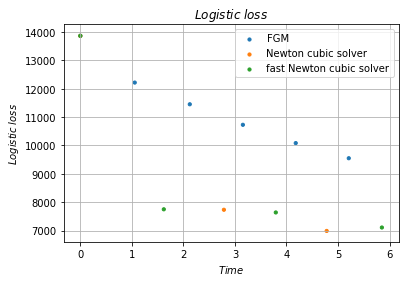

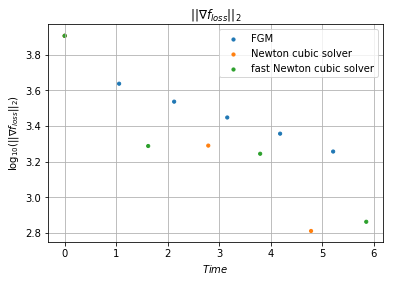

fast Newton cubic solver: за время Time = 5 секунд значение функции = 7110.3520315068945, норма градиента = 730.8796388157745
Newton cubic solver: за время Time = 5 секунд значение функции = 6989.525541648329, норма градиента = 649.0325403743653
FGM: за время Time = 5 секунд значение функции = 9550.612093858359, норма градиента = 1810.220403531661


In [84]:
features_extended = features + 1
w0 = np.zeros(features_extended)
NumIter = 30

train_const_feature = np.array([np.array([1]) for i in range(train_object_size)]) #добавим фиктивный признак
train_extended_object = copy.deepcopy(train_object)
train_extended_object = np.column_stack((train_extended_object, train_const_feature[:, 0]))
L = L2_upper_bound(train_extended_object)

work_time = 5
w0 = np.zeros(features_num)

args = (train_extended_object, train_ans)
Time_fgm, xans_fgm_time, farr_fgm_time, fgradarr_fgm_time = FGM_time(time.process_time(), work_time, w0, logistic_loss, 
                                                                              grad_logistic_loss, L, *args)

NumIterStep = 100
eps = 1e-10
L0 = 1e-10
Time_newton_cubic, xans_newton_cubic_time, farr_newton_cubic_time, fgradarr_newton_cubic_time = Newton_cubic_solver_time(
w0, time.process_time(), work_time, NumIterStep, logistic_loss, grad_logistic_loss, hessian_logistic_loss,  L0, eps,
                                                                                                                *args)

parts = 100000
L0 = L3_upper_bound(train_extended_object)/parts
Time_fast_newton, xans_fast_newton_time, farr_fast_newton_time, fgradarr_fast_newton_time = fast_Newton_cubic_solver_time(
w0, time.process_time(), work_time, NumIterStep, logistic_loss, grad_logistic_loss, hessian_logistic_loss,  L0, eps,
                                                                                                                *args)

NumIter_fgm = len(Time_fgm)
NumIter_newton_cubic = len(Time_newton_cubic)
NumIter_fast_newton = len(Time_fast_newton)
s_fgm = [10 for n in range(len(Time_fgm))]
s_newton_cubic = [10 for n in range(len(Time_newton_cubic))]
s_fast_newton = [10 for n in range(len(Time_fast_newton))]
fig = plt.figure()
plt.xlabel(r'$Time$') 
plt.ylabel(r'$Logistic \; loss$') 
plt.title(r'$Logistic \; loss$') 
plt.scatter(Time_fgm, farr_fgm_time, label = 'FGM', s = s_fgm)
plt.scatter(Time_newton_cubic, farr_newton_cubic_time, label = 'Newton cubic solver', s = s_newton_cubic)
plt.scatter(Time_fast_newton, farr_fast_newton_time, label = 'fast Newton cubic solver', s = s_fast_newton)
plt.legend()
plt.grid(True) 
fig.savefig('log_loss_all_f_time.pdf')
plt.show()

fig = plt.figure()
plt.xlabel(r'$Time$') 
plt.ylabel(r'$\log_{10}(||\nabla f_{loss}||_2)$') 
plt.title(r'$||\nabla f_{loss}||_2$') 
plt.scatter(Time_fgm, np.log10(fgradarr_fgm_time), label = 'FGM', s = s_fgm)
plt.scatter(Time_newton_cubic, np.log10(fgradarr_newton_cubic_time), label = 'Newton cubic solver', s = s_newton_cubic)
plt.scatter(Time_fast_newton, np.log10(fgradarr_fast_newton_time), label = 'fast Newton cubic solver', s = s_fast_newton)
plt.legend()
plt.grid(True) 
fig.savefig('log_loss_all_gradf_time.pdf')
plt.show()

print("fast Newton cubic solver: за время Time = {0} секунд значение функции = {1}, норма градиента = {2}".format(
work_time, farr_fast_newton_time[NumIter_fast_newton - 1], fgradarr_fast_newton_time[NumIter_fast_newton - 1]))
print("Newton cubic solver: за время Time = {0} секунд значение функции = {1}, норма градиента = {2}".format(work_time, 
            farr_newton_cubic_time[NumIter_newton_cubic - 1], fgradarr_newton_cubic_time[NumIter_newton_cubic - 1]))
print("FGM: за время Time = {0} секунд значение функции = {1}, норма градиента = {2}".format(work_time, 
                                            farr_fgm_time[NumIter_fgm - 1], fgradarr_fgm_time[NumIter_fgm - 1]))

# Сравнение с sklearn-вской Logistic Regression

/usr/local/lib64/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib64/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib64/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib64/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib64/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", Convergenc

iter = 0
||s|| - lambda = 0.0
iter = 1
||s|| - lambda = 0.0
iter = 2
||s|| - lambda = 0.0
iter = 3
||s|| - lambda = 0.0
iter = 4
||s|| - lambda = 0.0
iter = 5
||s|| - lambda = 0.0
iter = 6
||s|| - lambda = 0.0
iter = 7
||s|| - lambda = 0.0
iter = 8
||s|| - lambda = 0.0
iter = 9
||s|| - lambda = 0.0
iter = 10
||s|| - lambda = 0.0
iter = 11
||s|| - lambda = 0.0
iter = 12
||s|| - lambda = 0.0
iter = 13
||s|| - lambda = 0.0
iter = 14
||s|| - lambda = 0.0
iter = 15
||s|| - lambda = 0.0
iter = 16
||s|| - lambda = 0.0
iter = 17
||s|| - lambda = 0.0
iter = 18
||s|| - lambda = 0.0
iter = 19
||s|| - lambda = 0.0
iter = 20
||s|| - lambda = 0.0
iter = 21
||s|| - lambda = 0.0
iter = 22
||s|| - lambda = -5.169878828456423e-26
iter = 23
||s|| - lambda = 2.5849394142282115e-26
iter = 24
||s|| - lambda = 2.5849394142282115e-26
iter = 25
||s|| - lambda = 1.2924697071141057e-26
iter = 26
||s|| - lambda = 1.2924697071141057e-26
iter = 27
||s|| - lambda = 0.0
iter = 28
||s|| - lambda = 0.0
iter = 29
||s|| 

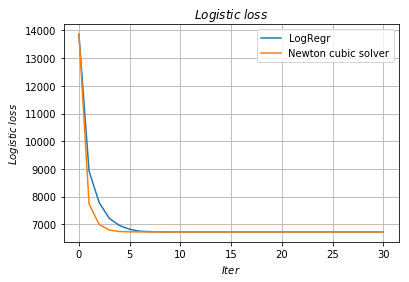

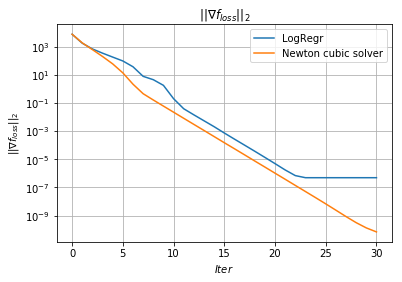

Newton cubic solver: после NumIter = 30 итераций значение функции = 6723.720030361996, норма градиента = 6.792901841829857e-11
LogRegr: после NumIter = 30 итераций значение функции = 6723.720031524326, норма градиента = 4.922332993474425e-07


In [86]:
NumIter = 30 
NumIterStep = 100
parts = 100000

logistic_loss_train = np.zeros(NumIter + 1)
norm_grad_loss_train = np.zeros(NumIter + 1)

for i in range(NumIter + 1):
    log_reg = LogisticRegression(solver = 'liblinear', tol = 1e-10, C = 100000000, max_iter = i)
    log_reg.fit(train_object, train_ans)
    
    coef = log_reg.coef_
    bias = log_reg.intercept_
    coef = np.append(coef, bias)

    train_args = (train_extended_object, train_ans)
    logistic_loss_train[i] = logistic_loss(coef, *train_args)
    norm_grad_loss_train[i] = linalg.norm(grad_logistic_loss(coef, *train_args))
    
L0 = 1e-10
eps = 1e-10
args = (train_extended_object, train_ans)
xans_newton_cubic, farr_newton_cubic, fgradarr_newton_cubic = Newton_cubic_solver_iter(w0, NumIter, NumIterStep, 
                                        logistic_loss, grad_logistic_loss, hessian_logistic_loss,  L0, eps, *args)
    
fig = plt.figure()
plt.xlabel(r'$Iter$') 
plt.ylabel(r'$Logistic \; loss$') 
plt.title(r'$Logistic \; loss$') 
plt.plot([i for i in range(NumIter + 1)], logistic_loss_train, label = 'LogRegr')
plt.plot([i for i in range(NumIter + 1)], farr_newton_cubic, label = 'Newton cubic solver')
plt.legend()
plt.grid(True) 
fig.savefig('loss_logregr+newton.pdf')
plt.show()

fig = plt.figure()
plt.xlabel(r'$Iter$') 
plt.ylabel(r'$||\nabla f_{loss}||_2$') 
plt.title(r'$||\nabla f_{loss}||_2$') 
plt.semilogy([i for i in range(NumIter + 1)], norm_grad_loss_train, label = 'LogRegr')
plt.semilogy([i for i in range(NumIter + 1)], fgradarr_newton_cubic, label = 'Newton cubic solver')
plt.legend()
plt.grid(True) 
fig.savefig('gradloss_logregr+newton.pdf')
plt.show()

print("Newton cubic solver: после NumIter = {0} итераций значение функции = {1}, норма градиента = {2}".format(NumIter, 
                                                        farr_newton_cubic[NumIter], fgradarr_newton_cubic[NumIter]))
print("LogRegr: после NumIter = {0} итераций значение функции = {1}, норма градиента = {2}".format(NumIter, 
                                                        logistic_loss_train[NumIter], norm_grad_loss_train[NumIter]))